In [1]:
import pandas                  as pd 
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import folium
import lightgbm                as lgb
from   sklearn.preprocessing   import StandardScaler , LabelEncoder
from   sklearn.model_selection import train_test_split
from   sklearn.cluster         import KMeans
from   pyclustering.cluster.kmedoids import kmedoids
import holidays
from   sklearn.metrics         import accuracy_score, classification_report, confusion_matrix
from   xgboost                 import XGBClassifier
from   sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 100)
df = pd.read_csv('train.csv')
df

Dates                Category  \
0       2015-05-13 23:53:00                WARRANTS   
1       2015-05-13 23:53:00          OTHER OFFENSES   
2       2015-05-13 23:33:00          OTHER OFFENSES   
3       2015-05-13 23:30:00           LARCENY/THEFT   
4       2015-05-13 23:30:00           LARCENY/THEFT   
...                     ...                     ...   
878044  2003-01-06 00:15:00                 ROBBERY   
878045  2003-01-06 00:01:00           LARCENY/THEFT   
878046  2003-01-06 00:01:00           LARCENY/THEFT   
878047  2003-01-06 00:01:00               VANDALISM   
878048  2003-01-06 00:01:00  FORGERY/COUNTERFEITING   

                                         Descript  DayOfWeek PdDistrict  \
0                                  WARRANT ARREST  Wednesday   NORTHERN   
1                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3                    GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4                    GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   
...                                           ...        ...        ...   
878044           ROBBERY ON THE STREET WITH A GUN     Monday    TARAVAL   
878045               GRAND THEFT FROM LOCKED AUTO     Monday  INGLESIDE   
878046               GRAND THEFT FROM LOCKED AUTO     Monday   SOUTHERN   
878047  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   SOUTHERN   
878048                   CHECKS, FORGERY (FELONY)     Monday    BAYVIEW   

            Resolution                     Address           X          Y  
0       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
1       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599  
2       ARREST, BOOKED   VANNESS AV / GREENWICH ST -122.424363  37.800414  
3                 NONE    1500 Block of LOMBARD ST -122.426995  37.800873  
4                 NONE   100 Block of BRODERICK ST -122.438738  37.771541  
...                ...                         ...         ...        ...  
878044            NONE  FARALLONES ST / CAPITOL AV -122.459033  37.714056  
878045            NONE        600 Block of EDNA ST -122.447364  37.731948  
878046            NONE          5TH ST / FOLSOM ST -122.403390  37.780266  
878047            NONE        TOWNSEND ST / 2ND ST -122.390531  37.780607  
878048            NONE    1800 Block of NEWCOMB AV -122.394926  37.738212  

[878049 rows x 9 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [4]:
df.describe()

X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000

In [5]:
df.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
def feature_engineering(df):
    df['Dates'] = pd.to_datetime(df['Dates'])
    df['Time'] = df['Dates'].dt.time
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    return df

In [7]:
df = feature_engineering(df)
df

Dates                Category  \
0      2015-05-13 23:53:00                WARRANTS   
1      2015-05-13 23:53:00          OTHER OFFENSES   
2      2015-05-13 23:33:00          OTHER OFFENSES   
3      2015-05-13 23:30:00           LARCENY/THEFT   
4      2015-05-13 23:30:00           LARCENY/THEFT   
...                    ...                     ...   
878044 2003-01-06 00:15:00                 ROBBERY   
878045 2003-01-06 00:01:00           LARCENY/THEFT   
878046 2003-01-06 00:01:00           LARCENY/THEFT   
878047 2003-01-06 00:01:00               VANDALISM   
878048 2003-01-06 00:01:00  FORGERY/COUNTERFEITING   

                                         Descript  DayOfWeek PdDistrict  \
0                                  WARRANT ARREST  Wednesday   NORTHERN   
1                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2                        TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3                    GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4                    GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   
...                                           ...        ...        ...   
878044           ROBBERY ON THE STREET WITH A GUN     Monday    TARAVAL   
878045               GRAND THEFT FROM LOCKED AUTO     Monday  INGLESIDE   
878046               GRAND THEFT FROM LOCKED AUTO     Monday   SOUTHERN   
878047  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   SOUTHERN   
878048                   CHECKS, FORGERY (FELONY)     Monday    BAYVIEW   

            Resolution                     Address           X          Y  \
0       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599   
1       ARREST, BOOKED          OAK ST / LAGUNA ST -122.425892  37.774599   
2       ARREST, BOOKED   VANNESS AV / GREENWICH ST -122.424363  37.800414   
3                 NONE    1500 Block of LOMBARD ST -122.426995  37.800873   
4                 NONE   100 Block of BRODERICK ST -122.438738  37.771541   
...                ...                         ...         ...        ...   
878044            NONE  FARALLONES ST / CAPITOL AV -122.459033  37.714056   
878045            NONE        600 Block of EDNA ST -122.447364  37.731948   
878046            NONE          5TH ST / FOLSOM ST -122.403390  37.780266   
878047            NONE        TOWNSEND ST / 2ND ST -122.390531  37.780607   
878048            NONE    1800 Block of NEWCOMB AV -122.394926  37.738212   

            Time  Year  Month  Day  Hour  
0       23:53:00  2015      5   13    23  
1       23:53:00  2015      5   13    23  
2       23:33:00  2015      5   13    23  
3       23:30:00  2015      5   13    23  
4       23:30:00  2015      5   13    23  
...          ...   ...    ...  ...   ...  
878044  00:15:00  2003      1    6     0  
878045  00:01:00  2003      1    6     0  
878046  00:01:00  2003      1    6     0  
878047  00:01:00  2003      1    6     0  
878048  00:01:00  2003      1    6     0  

[875726 rows x 14 columns]

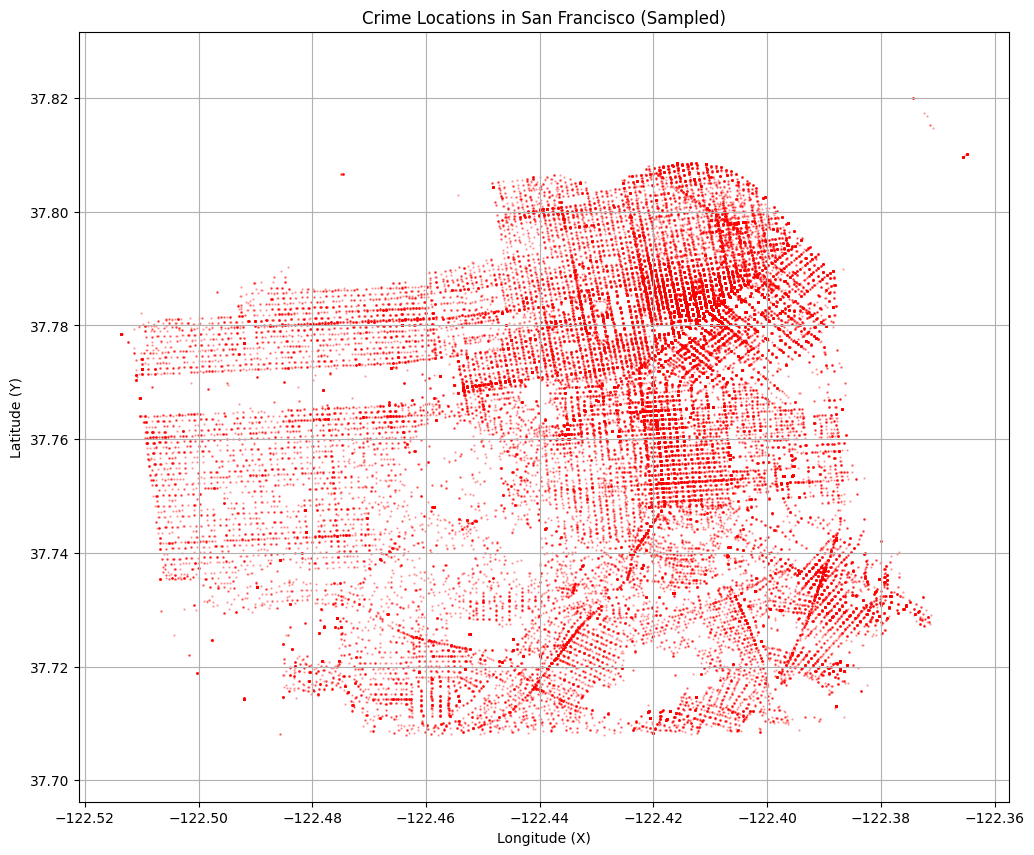

In [8]:
df = df[(df['X'] > -123) & (df['X'] < -121) &
                    (df['Y'] > 37) & (df['Y'] < 38)]
df_sample = df.sample(n=100000, random_state=42)

plt.figure(figsize=(12, 10))
plt.scatter(df_sample['X'], df_sample['Y'], s=0.5, alpha=0.3, c='red')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Locations in San Francisco (Sampled)')
plt.grid(True)
plt.axis('equal')
plt.show()

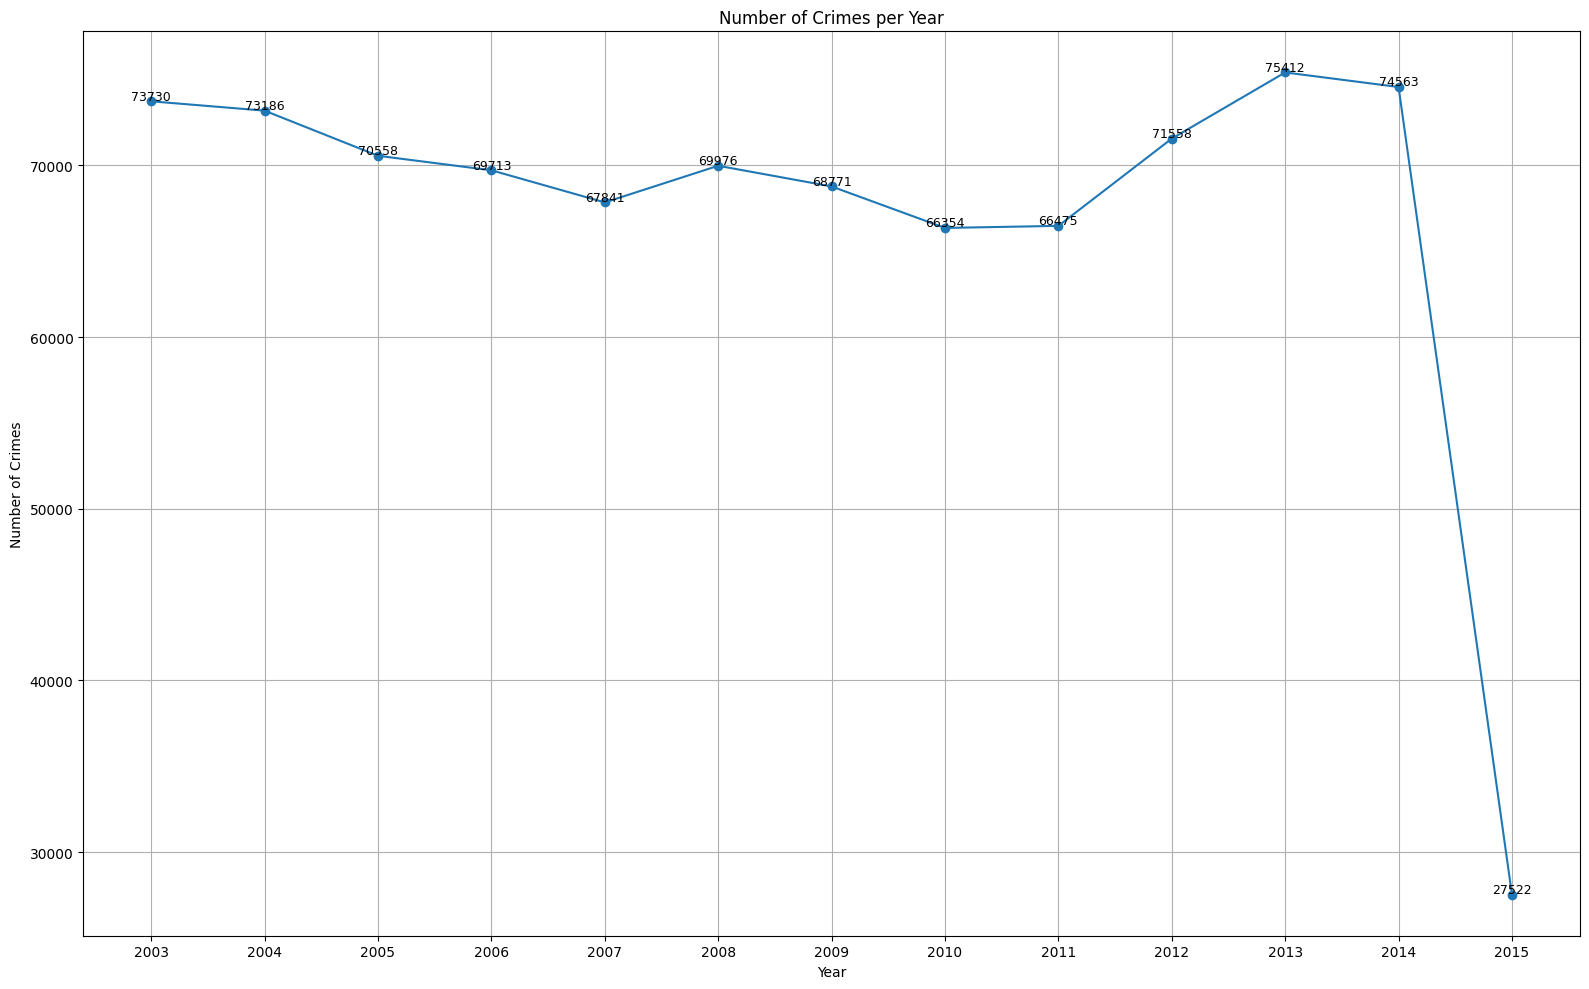

In [9]:
crimes_per_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(16,10))
plt.plot(crimes_per_year.index, crimes_per_year.values, marker='o', linestyle='-')
plt.title('Number of Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(crimes_per_year.index)  
for x, y in zip(crimes_per_year.index, crimes_per_year.values):
    plt.text(x, y + 100, str(y), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

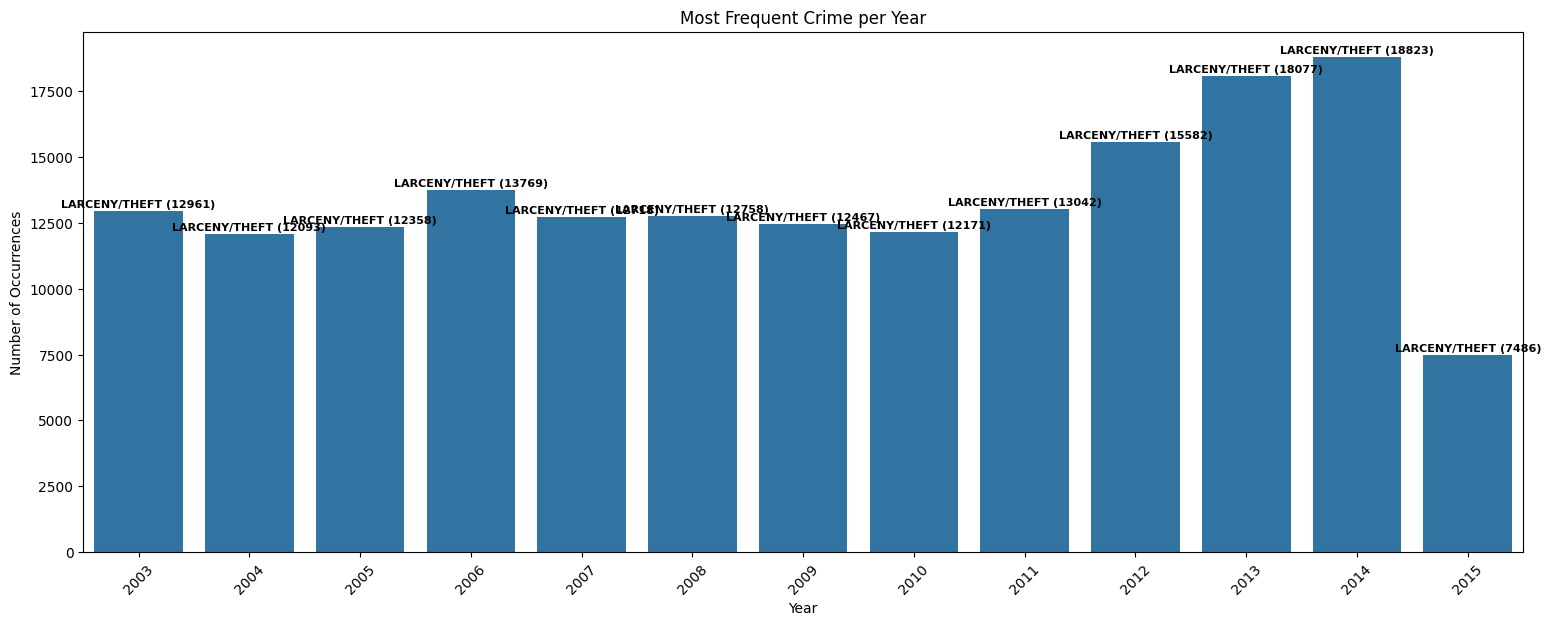

In [10]:
#اكثر الجرائم في كل السنه 
top_crimes_per_year = df.groupby('Year')['Category'].agg(lambda x: x.value_counts().idxmax())
top_crimes_count = df.groupby('Year')['Category'].agg(lambda x: x.value_counts().max())

top_crimes_df = pd.DataFrame({
    'Year': top_crimes_per_year.index,
    'Top Crime': top_crimes_per_year.values,
    'Count': top_crimes_count.values
})

top_crimes_df = top_crimes_df.drop_duplicates(subset=['Year'], keep='first')

plt.figure(figsize=(16, 8))  

sns.barplot(data=top_crimes_df, x='Year', y='Count', hue='Top Crime', dodge=False)

for index, row in top_crimes_df.iterrows():
    plt.text(x=index, y=row['Count'] + 50, 
             s=f"{row['Top Crime']} ({row['Count']})",  
             ha='center', va='bottom', fontsize=8, color='black', fontweight='bold')

plt.title('Most Frequent Crime per Year')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.legend().remove()  

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.25)
plt.show()

C:\Users\Mus6afa Younis\AppData\Local\Temp\ipykernel_3780\2733291186.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_counts.index, y=crime_counts.values, palette="viridis")


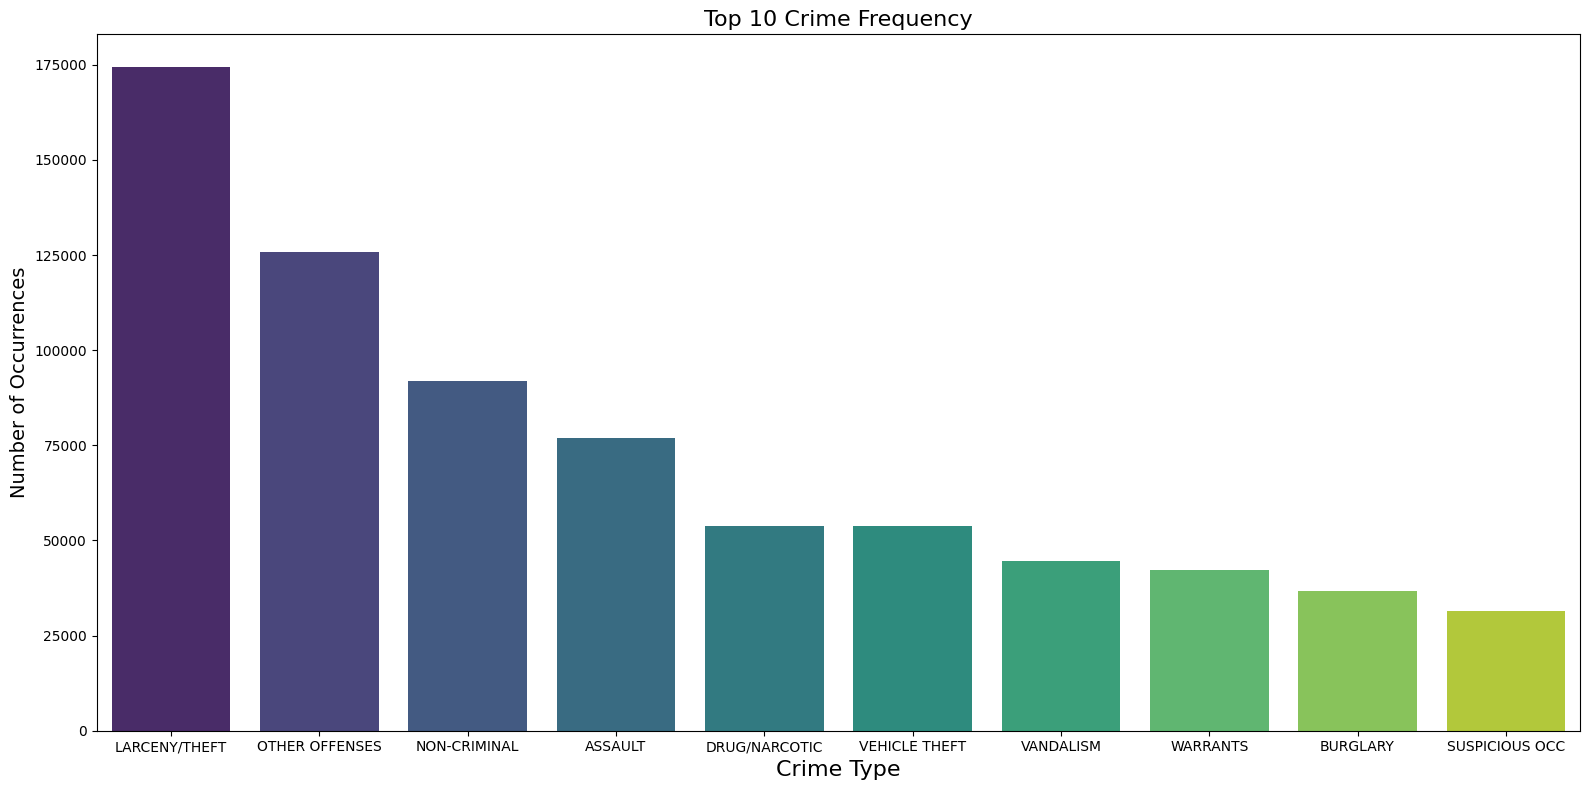

In [11]:
crime_counts = df['Category'].value_counts().head(10)

plt.figure(figsize=(16, 8))  

sns.barplot(x=crime_counts.index, y=crime_counts.values, palette="viridis")

plt.title('Top 10 Crime Frequency', fontsize=16)
plt.xlabel('Crime Type', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=14)

plt.tight_layout() 
plt.show()

In [12]:

df_sample = df.sample(n=10000, random_state=42)

map_center = [37.7749, -122.4194] 

crime_map = folium.Map(location=map_center, zoom_start=12)


for _, row in df_sample.iterrows():
    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5
    ).add_to(crime_map)

crime_map

C:\Users\Mus6afa Younis\AppData\Local\Temp\ipykernel_3780\2994970690.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_crime_per_hour, x='Hour', y='Count', palette='viridis')


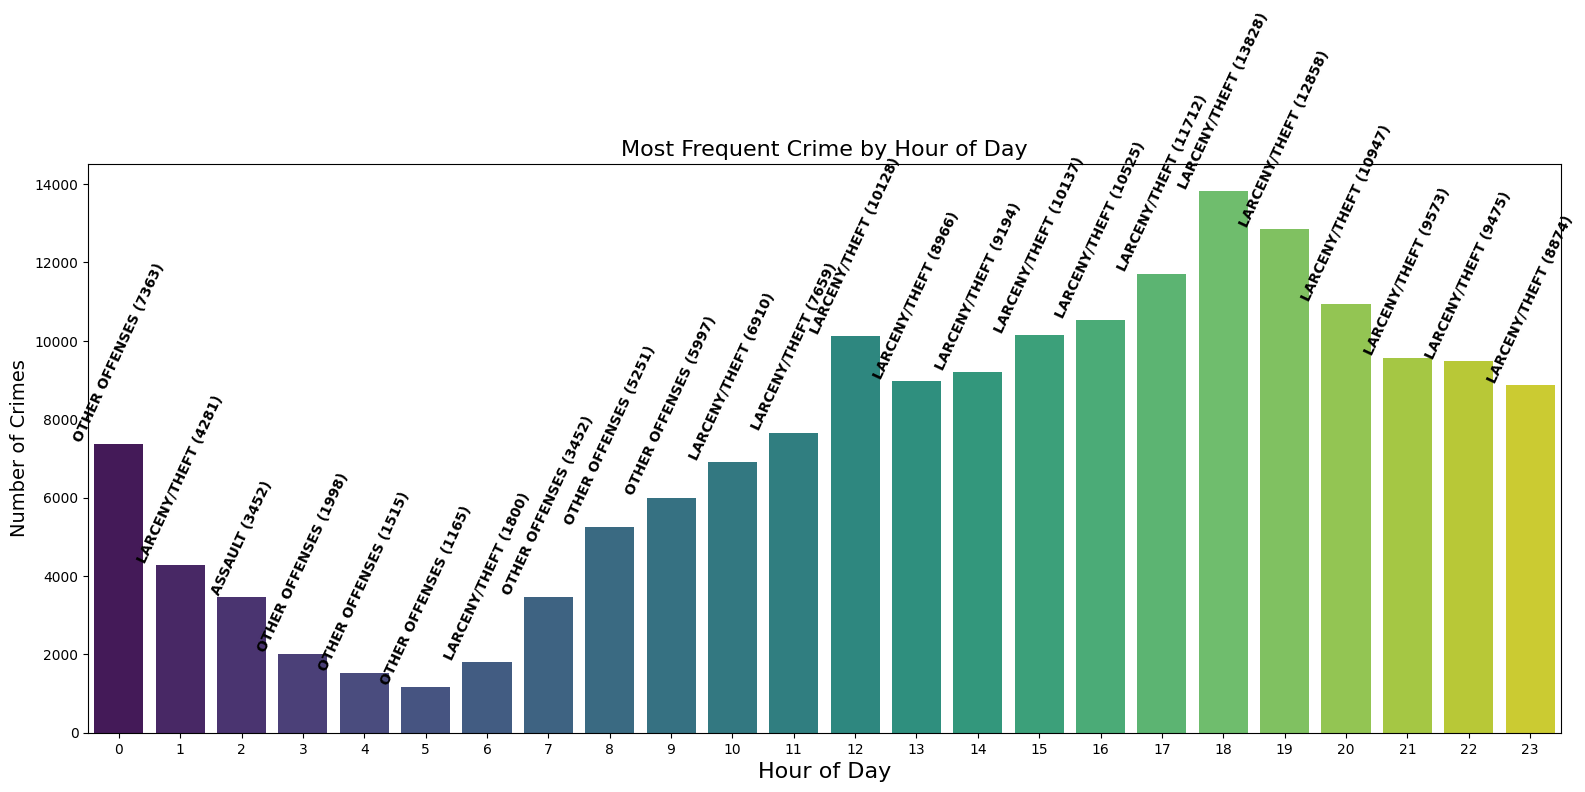

In [13]:
crime_by_hour_and_category = df.groupby(['Hour', 'Category']).size().reset_index(name='Count')

top_crime_per_hour = crime_by_hour_and_category.loc[crime_by_hour_and_category.groupby('Hour')['Count'].idxmax()]

plt.figure(figsize=(16, 8))

sns.barplot(data=top_crime_per_hour, x='Hour', y='Count', palette='viridis')

plt.title('Most Frequent Crime by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Number of Crimes', fontsize=14)


for index, row in top_crime_per_hour.iterrows():
    plt.text(x=row['Hour'], y=row['Count'] + 1, 
             s=f"{row['Category']} ({row['Count']})", 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold', rotation=65)

plt.tight_layout()
plt.show()

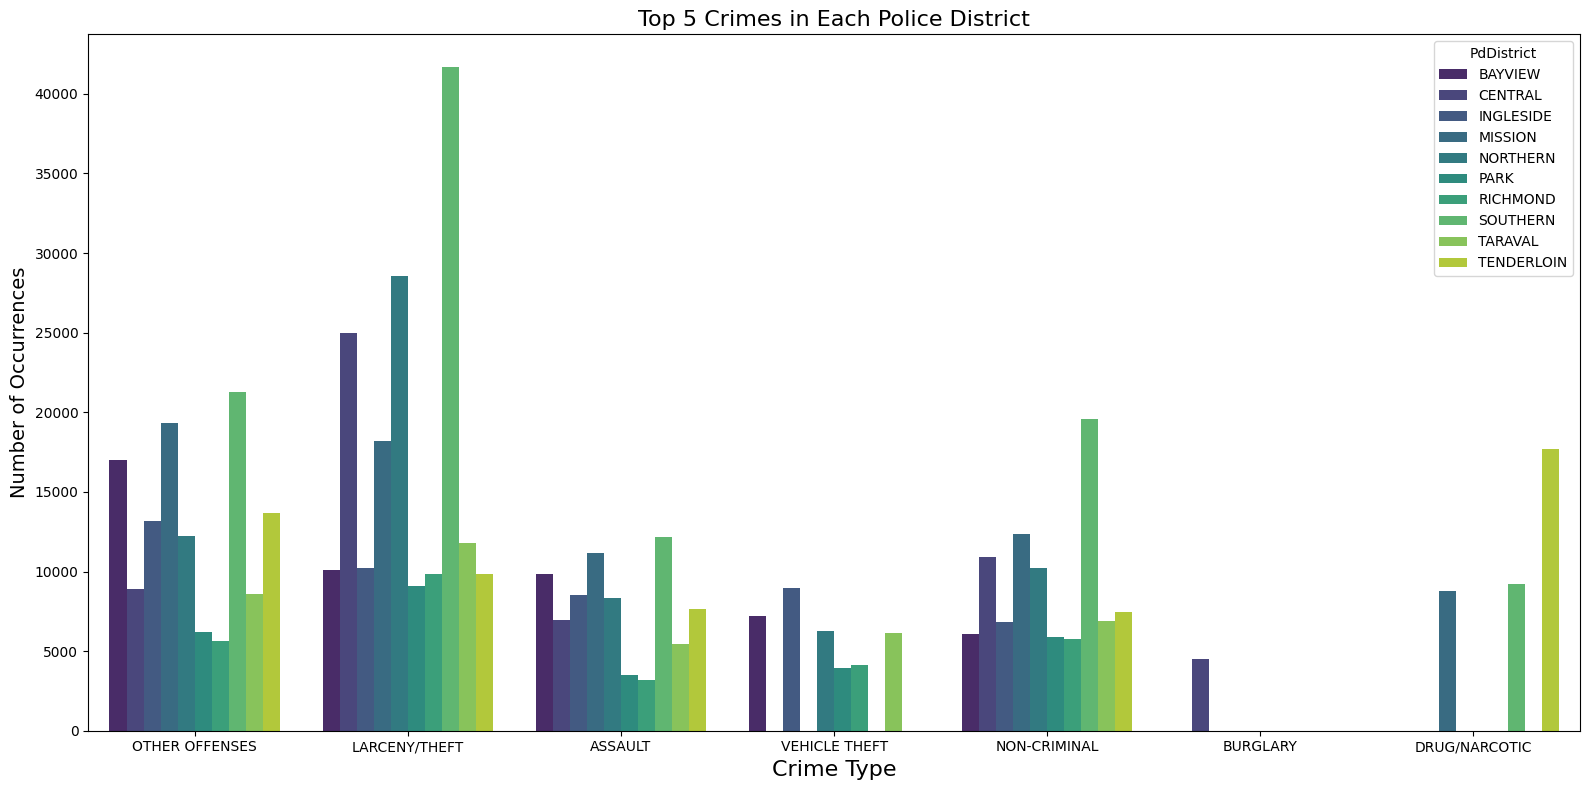

In [14]:
top_5_crimes_per_district = df.groupby('PdDistrict')['Category'].value_counts().groupby(level=0).head(5)

top_5_crimes_df = top_5_crimes_per_district.reset_index(name='Count')


plt.figure(figsize=(16, 8))
sns.barplot(data=top_5_crimes_df, x='Category', y='Count', hue='PdDistrict', palette='viridis')

plt.title('Top 5 Crimes in Each Police District', fontsize=16)
plt.xlabel('Crime Type', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=14)

plt.tight_layout()
plt.show()

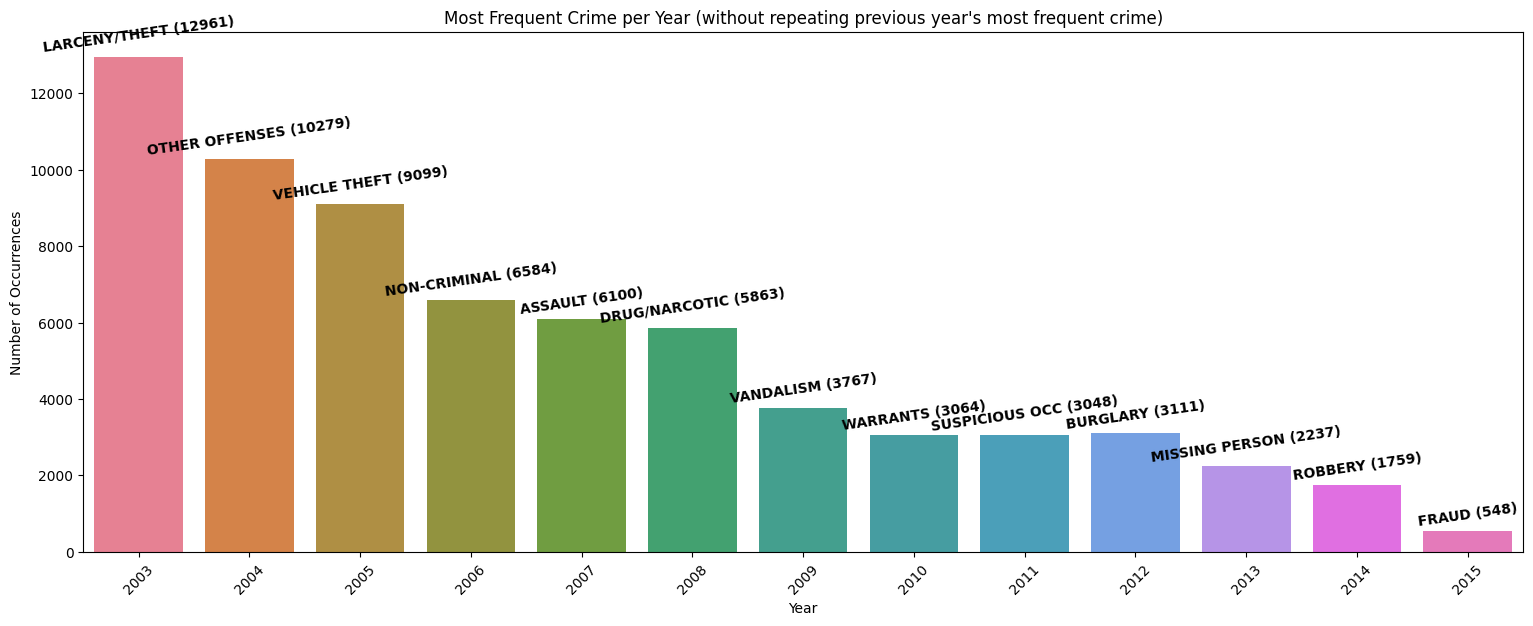

In [15]:
#اكثر جرائم تكرار في كل سنه مع عدم تكرار الجريمه 
top_crimes_per_year = df.groupby('Year')['Category'].agg(lambda x: x.value_counts().idxmax())
top_crimes_count = df.groupby('Year')['Category'].agg(lambda x: x.value_counts().max())


top_crimes_df = pd.DataFrame({
    'Year': top_crimes_per_year.index,
    'Top Crime': top_crimes_per_year.values,
    'Count': top_crimes_count.values
})

used_crimes = []

for index, row in top_crimes_df.iterrows():
    if row['Top Crime'] in used_crimes:
        remaining_crimes = df[df['Year'] == row['Year']]['Category'].value_counts()
        remaining_crimes = remaining_crimes[~remaining_crimes.index.isin(used_crimes)]  
        top_crimes_df.loc[index, 'Top Crime'] = remaining_crimes.idxmax()
        top_crimes_df.loc[index, 'Count'] = remaining_crimes.max()
    used_crimes.append(top_crimes_df.loc[index, 'Top Crime'])

plt.figure(figsize=(16, 8))  

sns.barplot(data=top_crimes_df, x='Year', y='Count', hue='Top Crime', dodge=False)

for index, row in top_crimes_df.iterrows():
    plt.text(x=index, y=row['Count'] + 50, 
             s=f"{row['Top Crime']} ({row['Count']})",
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold', rotation=8)


plt.title('Most Frequent Crime per Year (without repeating previous year\'s most frequent crime)')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.legend().remove()  

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.25)
plt.show()

In [16]:

df_sampled = df.sample(n=100000,random_state=42)
df_sampled = df_sampled.reset_index(drop=True)
df_sampled

Dates        Category                     Descript  \
0     2011-01-14 05:24:00         ASSAULT  INFLICT INJURY ON COHABITEE   
1     2003-10-29 09:40:00  OTHER OFFENSES             PAROLE VIOLATION   
2     2013-08-06 11:55:00   LARCENY/THEFT      GRAND THEFT FROM PERSON   
3     2008-10-01 18:00:00   LARCENY/THEFT       GRAND THEFT PICKPOCKET   
4     2014-03-23 02:50:00         ASSAULT                      BATTERY   
...                   ...             ...                          ...   
99995 2013-02-06 16:00:00  MISSING PERSON                 FOUND PERSON   
99996 2014-10-05 16:30:00   LARCENY/THEFT      GRAND THEFT OF PROPERTY   
99997 2007-10-04 10:00:00   LARCENY/THEFT       GRAND THEFT PICKPOCKET   
99998 2007-10-29 17:45:00       LOITERING                      BEGGING   
99999 2005-12-02 12:20:00   LARCENY/THEFT       PETTY THEFT WITH PRIOR   

       DayOfWeek PdDistrict      Resolution                         Address  \
0         Friday    MISSION  ARREST, BOOKED        2000 Block of MISSION ST   
1      Wednesday   SOUTHERN  ARREST, BOOKED           TAYLOR ST / MARKET ST   
2        Tuesday    MISSION  ARREST, BOOKED            16TH ST / MISSION ST   
3      Wednesday   NORTHERN            NONE           MARKET ST / CHURCH ST   
4         Sunday   NORTHERN            NONE          2100 Block of UNION ST   
...          ...        ...             ...                             ...   
99995  Wednesday    TARAVAL         LOCATED        0 Block of FARALLONES ST   
99996     Sunday   RICHMOND            NONE             FULTON ST / 25TH AV   
99997   Thursday   SOUTHERN            NONE          800 Block of BRYANT ST   
99998     Monday   SOUTHERN   ARREST, CITED  SOUTH VAN NESS AV / MISSION ST   
99999     Friday       PARK  ARREST, BOOKED          2600 Block of GEARY BL   

                X          Y      Time  Year  Month  Day  Hour  
0     -122.419658  37.764221  05:24:00  2011      1   14     5  
1     -122.410294  37.782231  09:40:00  2003     10   29     9  
2     -122.419672  37.765050  11:55:00  2013      8    6    11  
3     -122.428950  37.767503  18:00:00  2008     10    1    18  
4     -122.434695  37.797246  02:50:00  2014      3   23     2  
...           ...        ...       ...   ...    ...  ...   ...  
99995 -122.454154  37.714035  16:00:00  2013      2    6    16  
99996 -122.484195  37.772566  16:30:00  2014     10    5    16  
99997 -122.403405  37.775421  10:00:00  2007     10    4    10  
99998 -122.418619  37.773053  17:45:00  2007     10   29    17  
99999 -122.446613  37.782246  12:20:00  2005     12    2    12  

[100000 rows x 14 columns]

In [17]:
def handling_holidays(df):
    
    ca_holidays = holidays.US(state='CA')
    df['is_holiday'] = df['Dates'].dt.date.isin(ca_holidays).astype(int)
    df['is_weekend'] = (df['Dates'].dt.weekday >= 5).astype(int)
    df['is_month_start'] = df['Dates'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Dates'].dt.is_month_end.astype(int)

    df = df.drop(columns=['Dates'])
    return df

In [18]:
df_sampled = handling_holidays(df_sampled)
df_sampled

Category                     Descript  DayOfWeek PdDistrict  \
0             ASSAULT  INFLICT INJURY ON COHABITEE     Friday    MISSION   
1      OTHER OFFENSES             PAROLE VIOLATION  Wednesday   SOUTHERN   
2       LARCENY/THEFT      GRAND THEFT FROM PERSON    Tuesday    MISSION   
3       LARCENY/THEFT       GRAND THEFT PICKPOCKET  Wednesday   NORTHERN   
4             ASSAULT                      BATTERY     Sunday   NORTHERN   
...               ...                          ...        ...        ...   
99995  MISSING PERSON                 FOUND PERSON  Wednesday    TARAVAL   
99996   LARCENY/THEFT      GRAND THEFT OF PROPERTY     Sunday   RICHMOND   
99997   LARCENY/THEFT       GRAND THEFT PICKPOCKET   Thursday   SOUTHERN   
99998       LOITERING                      BEGGING     Monday   SOUTHERN   
99999   LARCENY/THEFT       PETTY THEFT WITH PRIOR     Friday       PARK   

           Resolution                         Address           X          Y  \
0      ARREST, BOOKED        2000 Block of MISSION ST -122.419658  37.764221   
1      ARREST, BOOKED           TAYLOR ST / MARKET ST -122.410294  37.782231   
2      ARREST, BOOKED            16TH ST / MISSION ST -122.419672  37.765050   
3                NONE           MARKET ST / CHURCH ST -122.428950  37.767503   
4                NONE          2100 Block of UNION ST -122.434695  37.797246   
...               ...                             ...         ...        ...   
99995         LOCATED        0 Block of FARALLONES ST -122.454154  37.714035   
99996            NONE             FULTON ST / 25TH AV -122.484195  37.772566   
99997            NONE          800 Block of BRYANT ST -122.403405  37.775421   
99998   ARREST, CITED  SOUTH VAN NESS AV / MISSION ST -122.418619  37.773053   
99999  ARREST, BOOKED          2600 Block of GEARY BL -122.446613  37.782246   

           Time  Year  Month  Day  Hour  is_holiday  is_weekend  \
0      05:24:00  2011      1   14     5           0           0   
1      09:40:00  2003     10   29     9           0           0   
2      11:55:00  2013      8    6    11           0           0   
3      18:00:00  2008     10    1    18           0           0   
4      02:50:00  2014      3   23     2           0           1   
...         ...   ...    ...  ...   ...         ...         ...   
99995  16:00:00  2013      2    6    16           0           0   
99996  16:30:00  2014     10    5    16           0           1   
99997  10:00:00  2007     10    4    10           0           0   
99998  17:45:00  2007     10   29    17           0           0   
99999  12:20:00  2005     12    2    12           0           0   

       is_month_start  is_month_end  
0                   0             0  
1                   0             0  
2                   0             0  
3                   1             0  
4                   0             0  
...               ...           ...  
99995               0             0  
99996               0             0  
99997               0             0  
99998               0             0  
99999               0             0  

[100000 rows x 17 columns]

In [19]:
df_sampled['Category'].nunique()

38

In [20]:
df_sampled['Category'].value_counts()

Category
LARCENY/THEFT                  20053
OTHER OFFENSES                 14302
NON-CRIMINAL                   10449
ASSAULT                         8902
VEHICLE THEFT                   6213
DRUG/NARCOTIC                   6207
VANDALISM                       5080
WARRANTS                        4762
BURGLARY                        4084
SUSPICIOUS OCC                  3503
MISSING PERSON                  2898
ROBBERY                         2624
FRAUD                           1912
FORGERY/COUNTERFEITING          1132
SECONDARY CODES                 1131
WEAPON LAWS                      948
PROSTITUTION                     883
TRESPASS                         801
STOLEN PROPERTY                  549
DRUNKENNESS                      530
SEX OFFENSES FORCIBLE            493
DISORDERLY CONDUCT               457
RECOVERED VEHICLE                380
KIDNAPPING                       267
DRIVING UNDER THE INFLUENCE      263
LIQUOR LAWS                      248
RUNAWAY                      

In [21]:
print(df_sampled['DayOfWeek'].value_counts())


DayOfWeek
Friday       15197
Wednesday    14630
Saturday     14610
Thursday     14134
Tuesday      14113
Monday       13907
Sunday       13409
Name: count, dtype: int64


In [22]:
def convert_to_decimal_hours(t):
        return t.hour + t.minute / 60 + t.second / 3600


In [23]:
def preprocessing(df):
    le = LabelEncoder()
    df_copy = df.copy()

    df_copy = df_copy.drop(columns=['Descript', 'Resolution', 'PdDistrict', 'Address'])

    category_counts = df_copy['Category'].value_counts()
    categories_to_drop = category_counts[category_counts < 1000].index
    df_copy = df_copy[~df_copy['Category'].isin(categories_to_drop)]
    
    category_counts = df_copy['Category'].value_counts()
    categories_to_merge = category_counts[category_counts < 2000].index
    df_copy['Category'] = df_copy['Category'].apply(lambda x: 'Others' if x in categories_to_merge else x)

    df_copy['Category'] = le.fit_transform(df_copy['Category'])

    df_copy['DayOfWeek'] = le.fit_transform(df_copy['DayOfWeek'])

    df_copy['Time'] = df_copy['Time'].apply(convert_to_decimal_hours)


    feature_columns = ['X', 'Y']
    scaler = StandardScaler()
    df_copy[feature_columns] = scaler.fit_transform(df_copy[feature_columns])

    return df_copy, scaler

In [24]:
df_preprocessed , scalar= preprocessing(df_sampled)
df_preprocessed

Category  DayOfWeek         X         Y       Time  Year  Month  Day  \
0             0          0  0.120342 -0.117238   5.400000  2011      1   14   
1             6          6  0.489077  0.627510   9.666667  2003     10   29   
2             3          5  0.119813 -0.082934  11.916667  2013      8    6   
3             3          6 -0.245513  0.018486  18.000000  2008     10    1   
4             0          3 -0.471718  1.248415   2.833333  2014      3   23   
...         ...        ...       ...       ...        ...   ...    ...  ...   
99993         2          4 -3.438132  0.217133  17.850000  2012     11   15   
99995         4          6 -1.237923 -2.192500  16.000000  2013      2    6   
99996         3          3 -2.420751  0.227855  16.500000  2014     10    5   
99997         3          4  0.760317  0.345909  10.000000  2007     10    4   
99999         3          0 -0.940982  0.628140  12.333333  2005     12    2   

       Hour  is_holiday  is_weekend  is_month_start  is_month_end  
0         5           0           0               0             0  
1         9           0           0               0             0  
2        11           0           0               0             0  
3        18           0           0               1             0  
4         2           0           1               0             0  
...     ...         ...         ...             ...           ...  
99993    17           0           0               0             0  
99995    16           0           0               0             0  
99996    16           0           1               0             0  
99997    10           0           0               0             0  
99999    12           0           0               0             0  

[93252 rows x 13 columns]

In [25]:
df_preprocessed['Category'].nunique()

13

In [26]:

def elbow(df, max_k=10):
    distortions = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_k+1), distortions, marker='o')
    plt.title('Elbow Method For Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Distortion)')
    plt.grid(True)
    plt.show()

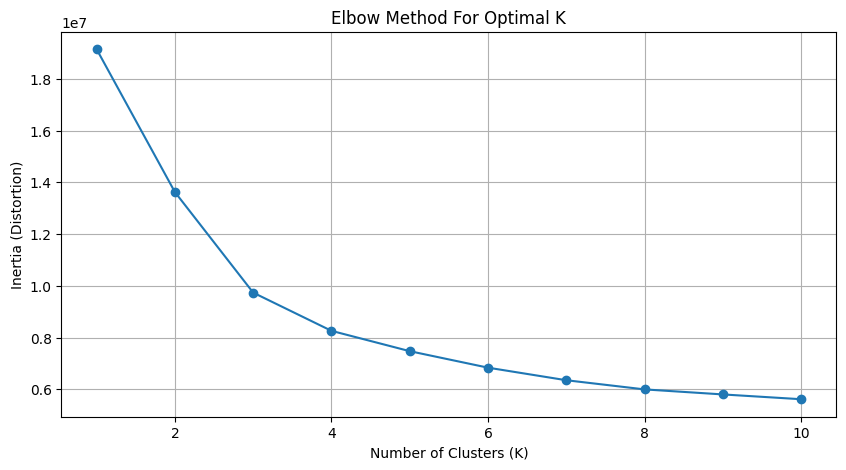

In [27]:
elbow(df_preprocessed)

In [28]:
df_clustered = df_preprocessed.sample(n=10000, random_state=42)


In [29]:
n_clusters = 4

initial_medoids = np.random.choice(df_clustered.shape[0], n_clusters, replace=False)

kmedoids_model = kmedoids(df_clustered.values.tolist(), initial_medoids)
kmedoids_model.process()

In [30]:
clusters = kmedoids_model.get_clusters()

cluster_labels = [-1] * len(df_clustered)
for cluster_id, cluster_points in enumerate(clusters,start=1):
    for point_index in cluster_points:
        cluster_labels[point_index] = cluster_id

df_clustered['cluster_labels'] = cluster_labels

In [31]:
df_clustered

Category  DayOfWeek         X         Y       Time  Year  Month  Day  \
12143        11          3  0.624397  0.482639  19.000000  2006     11    5   
45846         4          0 -0.043562 -0.726446  15.000000  2014      5    2   
3362          6          6  0.120342 -0.117238  10.583333  2010      7   14   
41671         0          0  0.158037 -0.080463  20.000000  2007      9    7   
61549         6          5 -0.294521 -1.800261  12.000000  2005      6   28   
...         ...        ...       ...       ...        ...   ...    ...  ...   
4563          3          4  0.021016  0.412850  17.416667  2003     10   16   
77432        10          4 -0.261319  0.844974  22.200000  2011      5    5   
52790         6          3  0.708715 -1.525673  17.000000  2006     10    8   
22060         9          3  0.308544  0.644172   7.000000  2006      1   29   
21671         7          1 -1.583774  0.460674  10.000000  2010     11    1   

       Hour  is_holiday  is_weekend  is_month_start  is_month_end  \
12143    19           0           1               0             0   
45846    15           0           0               0             0   
3362     10           0           0               0             0   
41671    20           0           0               0             0   
61549    12           0           0               0             0   
...     ...         ...         ...             ...           ...   
4563     17           0           0               0             0   
77432    22           0           0               0             0   
52790    17           0           1               0             0   
22060     7           0           1               0             0   
21671    10           0           0               1             0   

       cluster_labels  
12143               4  
45846               4  
3362                4  
41671               4  
61549               3  
...               ...  
4563                4  
77432               4  
52790               4  
22060               3  
21671               4  

[10000 rows x 14 columns]

In [32]:
cluster_summary = df_clustered.groupby('cluster_labels').agg({
    'Category': 'count',
    'Time': 'mean',
    'is_holiday': 'mean',
    'is_weekend': 'mean',
    'is_month_start': 'mean',
    'is_month_end': 'mean'
}).rename(columns={'Category': 'Crime_Count'})

cluster_summary['Time'] = cluster_summary['Time'].round(2)

cluster_summary = cluster_summary.sort_values('Crime_Count', ascending=False)

print("\n📊 Cluster Summary:\n")
cluster_summary


📊 Cluster Summary:



Crime_Count   Time  is_holiday  is_weekend  is_month_start  \
cluster_labels                                                               
4                      3639  16.11         0.0    0.262984        0.073647   
2                      2405  19.95         0.0    0.292308        0.000000   
3                      2176  11.92         0.0    0.254136        0.000000   
1                      1780   3.38         0.0    0.324157        0.050562   

                is_month_end  
cluster_labels                
4                   0.000000  
2                   0.043659  
3                   0.091452  
1                   0.011236

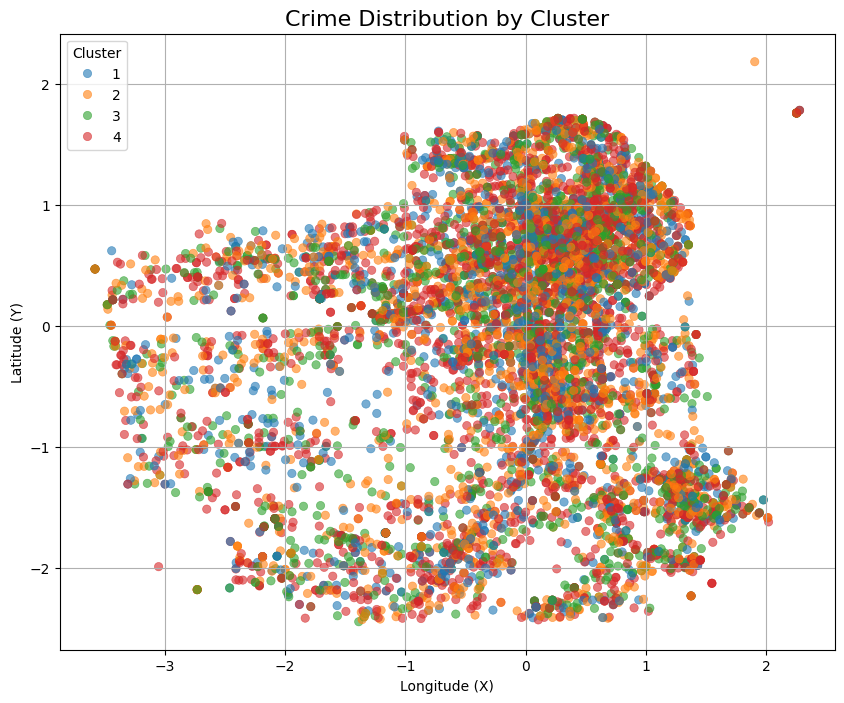

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", n_colors=n_clusters)

sns.scatterplot(
    data=df_clustered,
    x='X', y='Y',
    hue='cluster_labels',
    palette=palette,
    alpha=0.6,
    edgecolor=None
)

plt.title('Crime Distribution by Cluster', fontsize=16)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [34]:
df_clustered['cluster_labels'].nunique()

4

In [35]:
df_clustered['cluster_labels'].value_counts()

cluster_labels
4    3639
2    2405
3    2176
1    1780
Name: count, dtype: int64

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_evaluate_random_forest(df):

    X = df.drop(columns=['Category', 'cluster_labels'])
    y = df['cluster_labels']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

Accuracy: 96.95%

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       348
           2       0.97      0.96      0.96       499
           3       0.96      0.96      0.96       435
           4       0.98      0.98      0.98       718

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



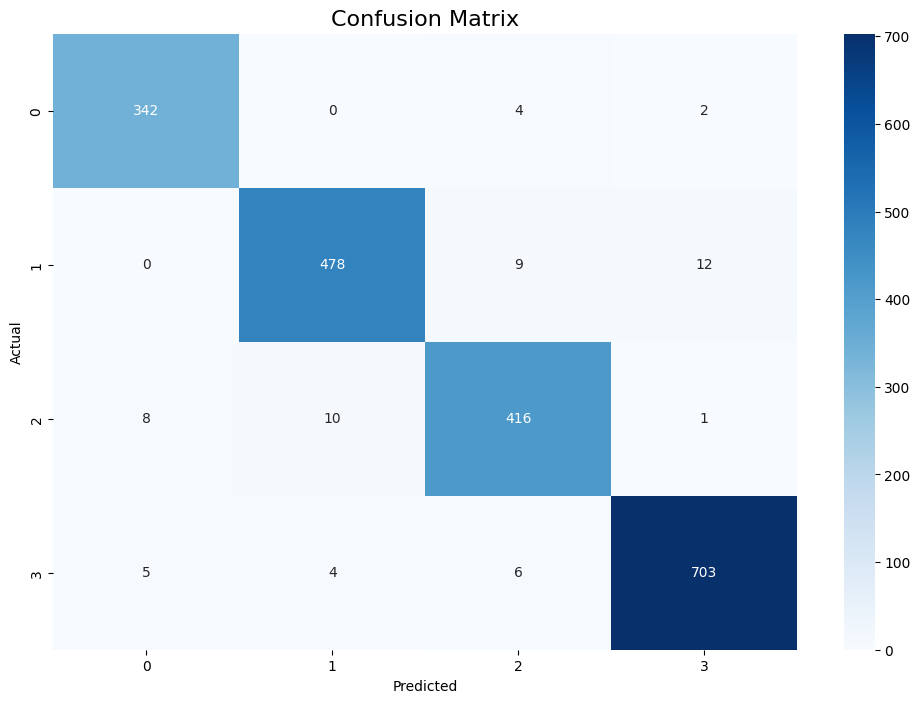

In [37]:
model = train_and_evaluate_random_forest(df_clustered)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_knn(df, n_neighbors=5):
    X = df.drop(columns=['Category', 'cluster_labels'])
    y = df['cluster_labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model


Accuracy: 95.40%

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97       348
           2       0.94      0.94      0.94       499
           3       0.93      0.93      0.93       435
           4       0.97      0.97      0.97       718

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



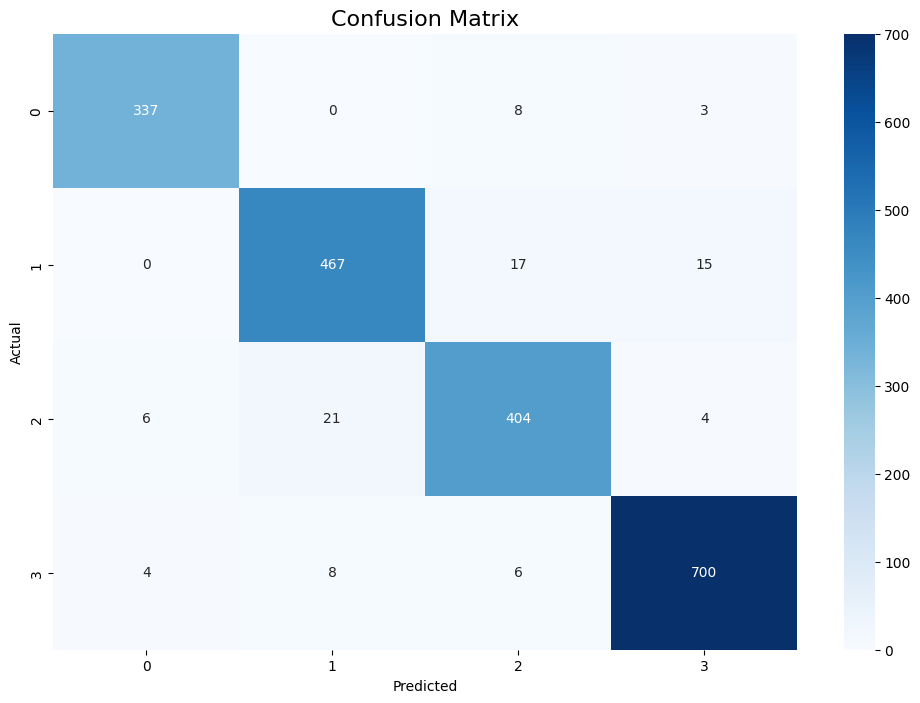

In [39]:
model = train_and_evaluate_knn(df_clustered)